In [1]:
import zipfile as zf

In [3]:
files = zf.ZipFile("Fingerprints.zip", 'r')
files.extractall('Fingerprints')
files.close()

In [1]:
import os
import sys
import pathlib

import numpy as np
import matplotlib.pyplot as plt


import tensorflow as tf

In [77]:

base_dir = pathlib.Path("fingerprints_gan")
img_dir = "Fingerprints/Fingerprints"
out_dir = "generated"

if not os.path.isdir(out_dir):
    os.mkdir(out_dir)

batch_size = 32 # 128
img_size = 64

dataset = tf.keras.utils.image_dataset_from_directory(
    img_dir,
    label_mode=None,
    image_size=(img_size, img_size),
    batch_size=batch_size,
    smart_resize=True
)

Found 6000 files belonging to 1 classes.


In [17]:
for x in dataset:
  print(x.numpy().shape)
  break

(32, 64, 64, 3)


In [18]:
dataset_numpy = np.concatenate(list(dataset.as_numpy_iterator()), axis=0)

min_value = np.min(dataset_numpy)
max_value = np.max(dataset_numpy)

print("Minimum pixel value:", min_value)
print("Maximum pixel value:", max_value)


Minimum pixel value: 0.0
Maximum pixel value: 255.0


In [78]:
dataset = dataset.map(lambda x: (x / 127.5) - 1.0) #normalize input between -1 and 1 (instead of 0 and 1)

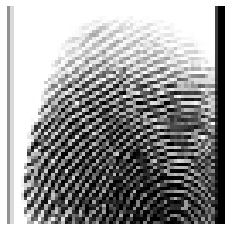

In [79]:
for x in dataset:
    plt.axis("off")
    plt.imshow(((x.numpy() + 1) / 2).astype("float32")[0])
    break


In [80]:
for x in dataset:
  print((((x.numpy() + 1) / 2).astype("float32")[0]).shape) 
  break

(64, 64, 3)


In [81]:
def build_discriminator():
    return tf.keras.Sequential(
        [
            tf.keras.Input(shape=(64, 64, 3)),
            tf.keras.layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
            tf.keras.layers.LeakyReLU(alpha=0.2),
            tf.keras.layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
            tf.keras.layers.LeakyReLU(alpha=0.2),
            tf.keras.layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
            tf.keras.layers.LeakyReLU(alpha=0.2),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(1, activation="sigmoid"),
        ],
        name="discriminator",
    )
discriminator = build_discriminator()

In [82]:
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 32, 32, 64)        3136      
                                                                 
 leaky_re_lu_18 (LeakyReLU)  (None, 32, 32, 64)        0         
                                                                 
 conv2d_13 (Conv2D)          (None, 16, 16, 128)       131200    
                                                                 
 leaky_re_lu_19 (LeakyReLU)  (None, 16, 16, 128)       0         
                                                                 
 conv2d_14 (Conv2D)          (None, 8, 8, 128)         262272    
                                                                 
 leaky_re_lu_20 (LeakyReLU)  (None, 8, 8, 128)         0         
                                                                 
 flatten_3 (Flatten)         (None, 8192)            

In [83]:
def build_generator(latent_dim = 128):
    return tf.keras.Sequential(
        [
            tf.keras.Input(shape=(latent_dim,)),
            tf.keras.layers.Dense(8 * 8 * 128),
            tf.keras.layers.Reshape((8, 8, 128)),
            tf.keras.layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
            tf.keras.layers.LeakyReLU(alpha=0.2),
            tf.keras.layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
            tf.keras.layers.LeakyReLU(alpha=0.2),
            tf.keras.layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
            tf.keras.layers.LeakyReLU(alpha=0.2),
            tf.keras.layers.Conv2D(3, kernel_size=5, padding="same", activation="tanh"),
        ],
        name="generator",
    )

generator = build_generator()

In [84]:
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 8192)              1056768   
                                                                 
 reshape_3 (Reshape)         (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_9 (Conv2D  (None, 16, 16, 128)       262272    
 Transpose)                                                      
                                                                 
 leaky_re_lu_21 (LeakyReLU)  (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_10 (Conv2  (None, 32, 32, 256)       524544    
 DTranspose)                                                     
                                                                 
 leaky_re_lu_22 (LeakyReLU)  (None, 32, 32, 256)       0 

In [101]:
class GAN(tf.keras.Model):                                                  # subclassing `tf.keras.Model`
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_loss_metric = tf.keras.metrics.Mean(name="d_loss")           # custom metrics
        self.g_loss_metric = tf.keras.metrics.Mean(name="g_loss")

    def compile(self, d_optimizer, g_optimizer, loss_fn):                   # `compile` required for `tf.keras.Model`
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):                                       # `train_step` required for `tf.keras.Model`
        batch_size = tf.shape(real_images)[0]

        # 1. TRAIN DISCRIMINATOR --------------------------------------------------
        for _ in range(2):
            random_latent_vectors = tf.random.normal(                            # feed a batch of generated
              shape=(batch_size, self.latent_dim)
            )

            generated_images = self.generator(random_latent_vectors)
            combined_images = tf.concat([generated_images, real_images], axis=0) # & real images
            # Label smoothing
            labels = tf.concat( # (fake: 0, real: 1)
                [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))],
                axis=0
            )
            real_labels = tf.random.uniform(tf.shape(labels), 0.0, 0.3)  # Smoothing for real images
            fake_labels = tf.random.uniform(tf.shape(labels), 0.7, 0.1)  # Smoothing for fake images
            smoothed_labels = tf.concat([real_labels[:batch_size], fake_labels[batch_size:]], axis=0)
            # (↓ label smoothing: inject randomness in the labels)
            smoothed_labels += 0.05 * tf.random.uniform(tf.shape(smoothed_labels))



            with tf.GradientTape() as tape:                                      # gradient logic:
                predictions = self.discriminator(combined_images)                # Discriminator predicts
                d_loss = self.loss_fn(labels, predictions)
            grads = tape.gradient(d_loss, self.discriminator.trainable_weights)  # gradients to update
            self.d_optimizer.apply_gradients(                                    # our Discriminator
                zip(grads, self.discriminator.trainable_weights)
            )
            self.d_loss_metric.update_state(d_loss) # update loss

        # 2. TRAIN GENERATOR ------------------------------------------------------

        # Sample from a spherical latent space
        random_latent_vectors_spherical = self.sample_spherical_latent_vectors(batch_size)

        misleading_labels = tf.zeros((batch_size, 1)) # 0: real

        with tf.GradientTape() as tape:                                 # gradient logic:
            predictions = self.discriminator(                           # get predictions from Discriminator
                self.generator(random_latent_vectors)                   # from generated fake images
            )
            g_loss = self.loss_fn(misleading_labels, predictions)       # loss labels vs preds
        grads = tape.gradient(g_loss, self.generator.trainable_weights) # gradients to update
        self.g_optimizer.apply_gradients(                               # our Generator
            zip(grads, self.generator.trainable_weights)
        )
        self.g_loss_metric.update_state(g_loss) # update loss

        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result()
        }

    def sample_spherical_latent_vectors(self, batch_size):
        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim)
        )
        normalized_latent_vectors = tf.math.l2_normalize(random_latent_vectors, axis=1)
        return normalized_latent_vectors

In [102]:
class GANMonitor(tf.keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128, show_every=1, save=True):
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.save = save
        self.show_every = show_every

    def on_epoch_end(self, epoch, logs=None):

        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images = (generated_images + 1) * 127.5
        generated_images.numpy()

        if self.save:
            for i in range(self.num_img):
                img = tf.keras.utils.array_to_img(generated_images[i])
                img.save(f'generated/generated_img_{epoch:03d}_{i}.png')

        if epoch % self.show_every != 0:
            return
        
        _, axs = plt.subplots(2,2, figsize=(12,12)) # https://stackoverflow.com/a/54681765
        axs = axs.flatten()
        for i, (img, ax) in enumerate(zip(generated_images, axs)):
            img = tf.keras.utils.array_to_img(img)
            ax.axis('off')
            ax.imshow(img)
        plt.show()
        


In [103]:
epochs = 10 
latent_dim = 128

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)

gan.compile(
    d_optimizer=tf.keras.optimizers.SGD(learning_rate=0.0002), 
    g_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002),
    loss_fn=tf.keras.losses.BinaryCrossentropy(),
)

In [104]:
reload = False 
generator_path = "generator_fingerptint_gan.h5"
discriminator_path = "discriminator_fingerptint_gan.h5"
if os.path.isfile(discriminator_path) and os.path.isfile(generator_path) and reload:
    gan.generator.load_weights(generator_path)
    gan.discriminator.load_weights(discriminator_path)

Epoch 1/10
188/188 [==============================] - ETA: 0s - d_loss: 0.7747 - g_loss: 0.5223

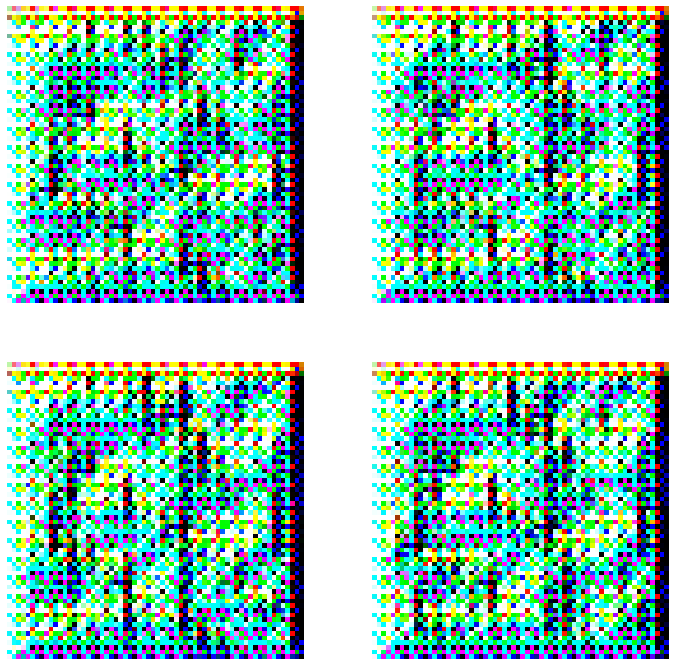

188/188 [==============================] - 214s 1s/step - d_loss: 0.7747 - g_loss: 0.5223
Epoch 2/10
188/188 [==============================] - ETA: 0s - d_loss: 0.8369 - g_loss: 0.4361

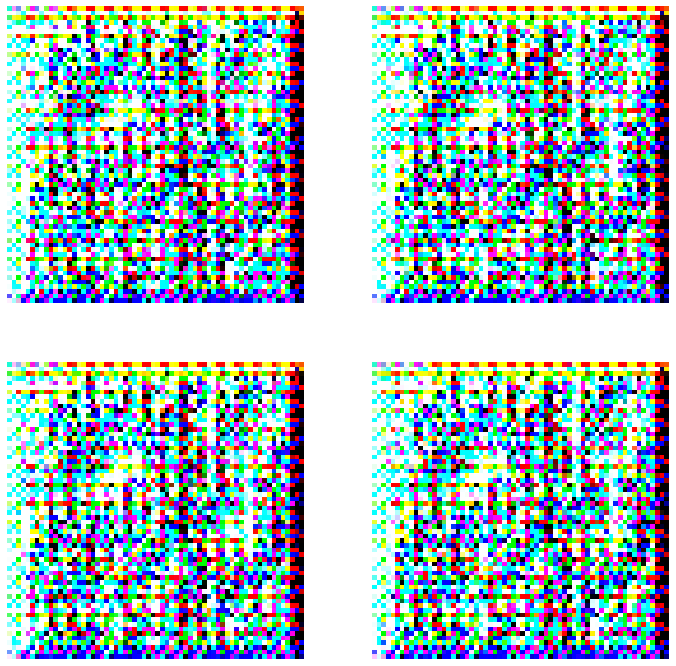

188/188 [==============================] - 213s 1s/step - d_loss: 0.8369 - g_loss: 0.4361
Epoch 3/10
188/188 [==============================] - ETA: 0s - d_loss: 1.0714 - g_loss: 0.2840

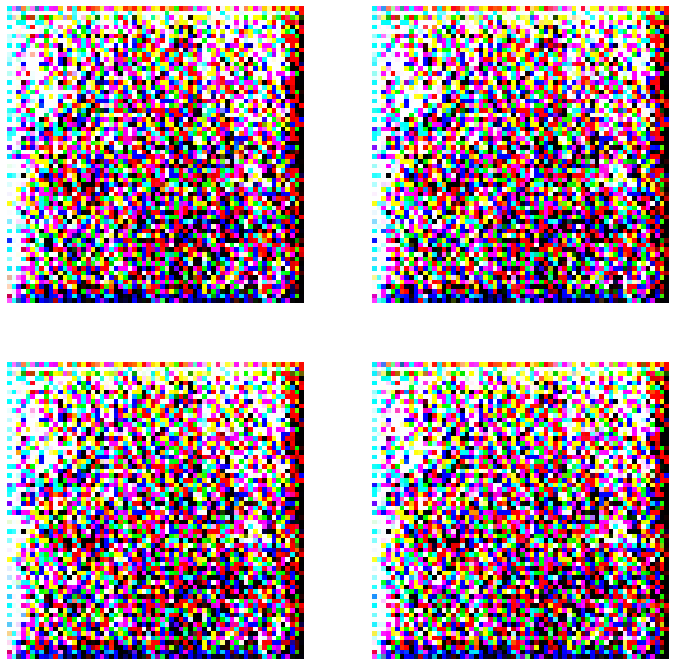

188/188 [==============================] - 211s 1s/step - d_loss: 1.0714 - g_loss: 0.2840
Epoch 4/10
188/188 [==============================] - ETA: 0s - d_loss: 1.1624 - g_loss: 0.2710

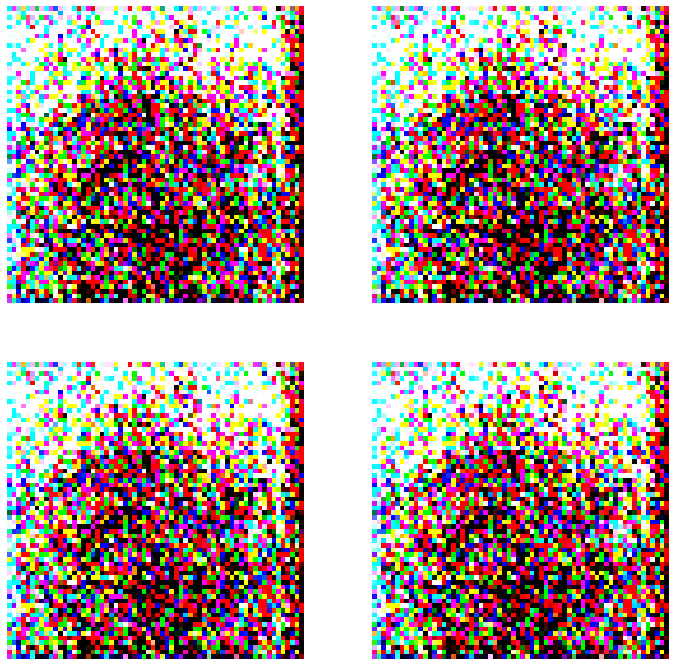

188/188 [==============================] - 211s 1s/step - d_loss: 1.1624 - g_loss: 0.2710
Epoch 5/10
188/188 [==============================] - ETA: 0s - d_loss: 1.1159 - g_loss: 0.3908

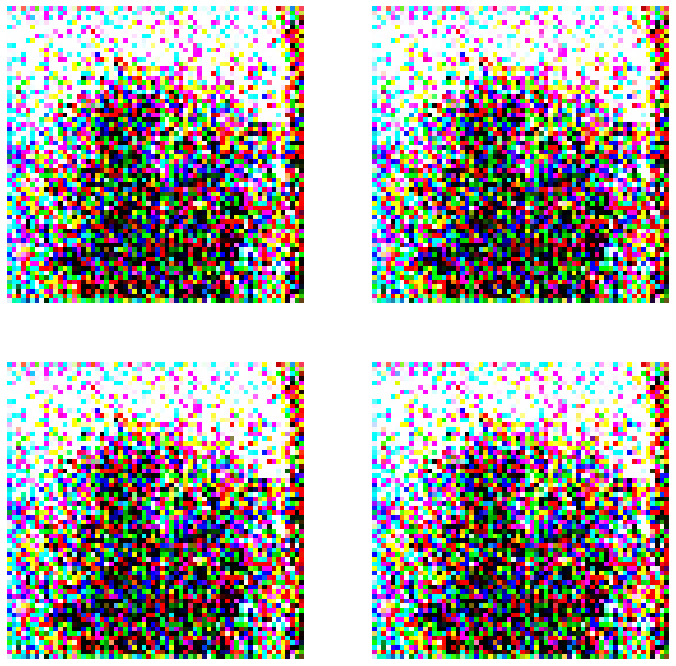

188/188 [==============================] - 211s 1s/step - d_loss: 1.1159 - g_loss: 0.3908
Epoch 6/10
188/188 [==============================] - ETA: 0s - d_loss: 1.0783 - g_loss: 0.4596

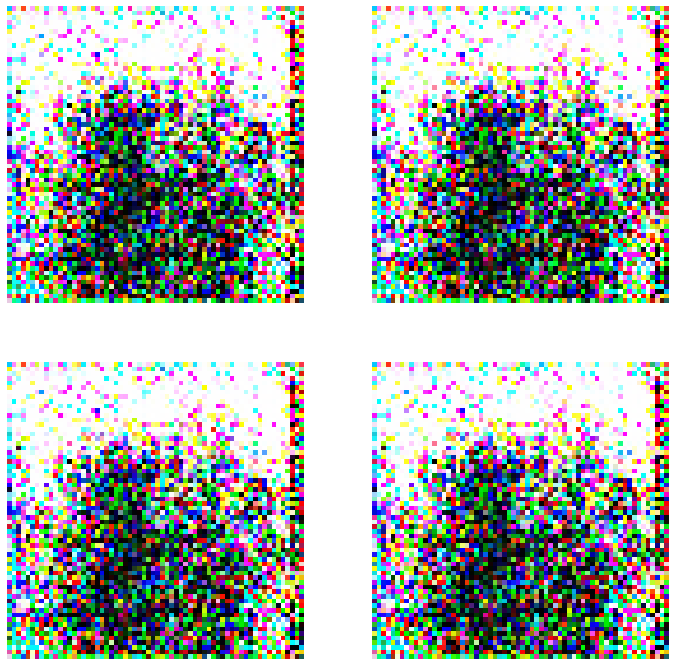

188/188 [==============================] - 211s 1s/step - d_loss: 1.0783 - g_loss: 0.4596
Epoch 7/10
188/188 [==============================] - ETA: 0s - d_loss: 1.0644 - g_loss: 0.4710

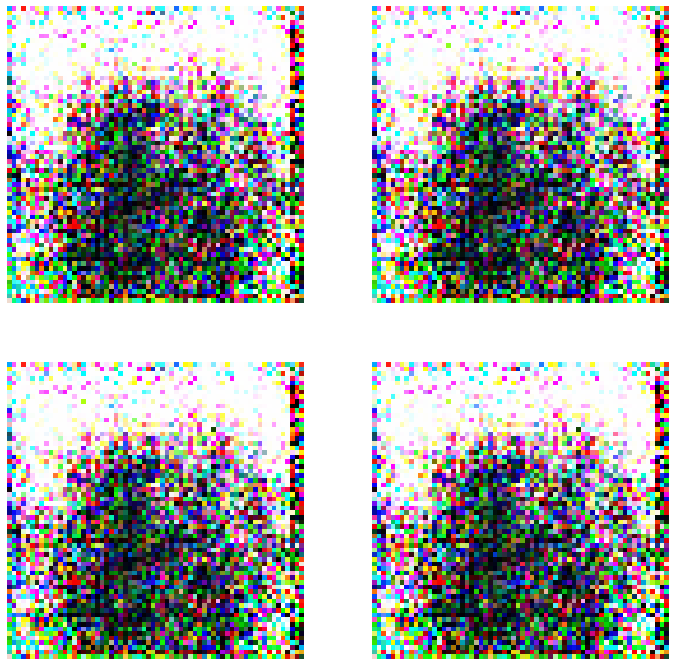

188/188 [==============================] - 211s 1s/step - d_loss: 1.0644 - g_loss: 0.4710
Epoch 8/10
188/188 [==============================] - ETA: 0s - d_loss: 1.0250 - g_loss: 0.4756

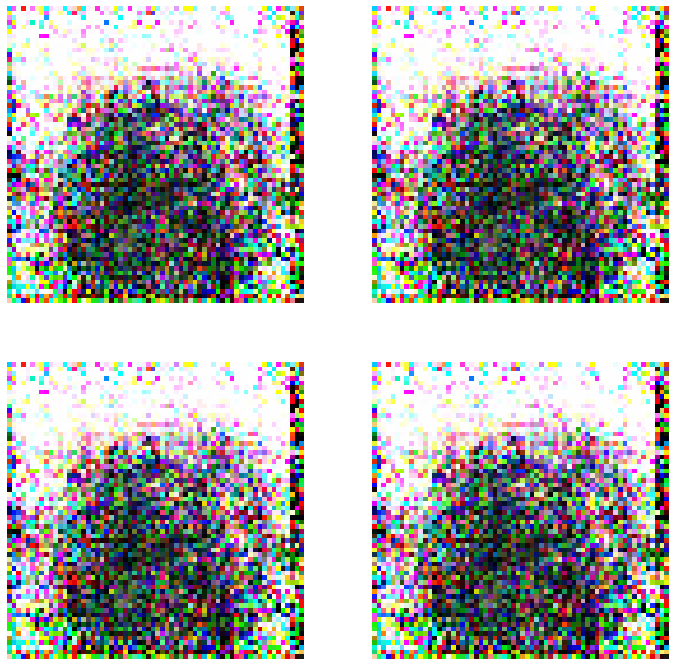

188/188 [==============================] - 211s 1s/step - d_loss: 1.0250 - g_loss: 0.4756
Epoch 9/10
188/188 [==============================] - ETA: 0s - d_loss: 0.9856 - g_loss: 0.4819

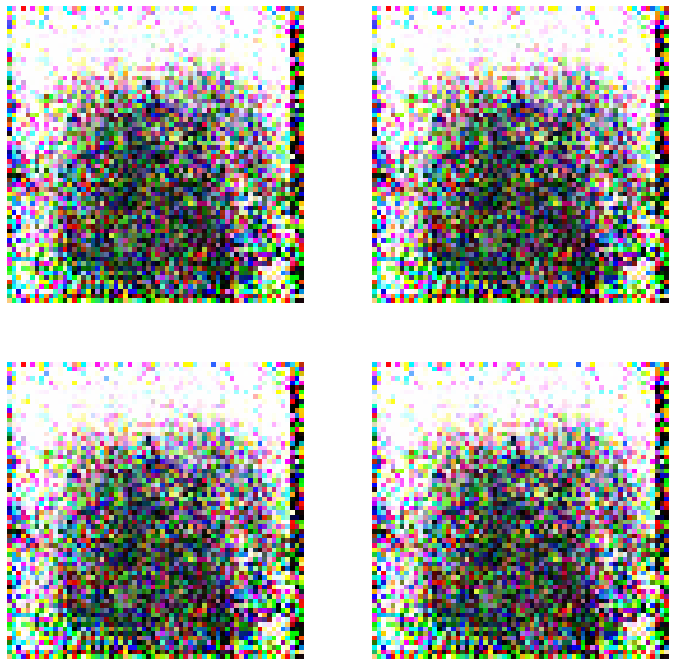

188/188 [==============================] - 210s 1s/step - d_loss: 0.9856 - g_loss: 0.4819
Epoch 10/10
188/188 [==============================] - ETA: 0s - d_loss: 0.9451 - g_loss: 0.4979

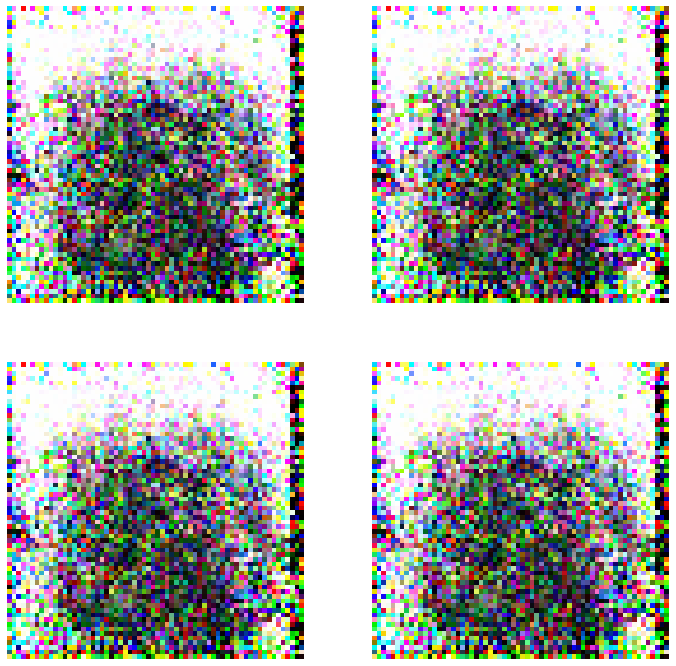

188/188 [==============================] - 214s 1s/step - d_loss: 0.9451 - g_loss: 0.4979


In [105]:
gan.fit(
    dataset, epochs=epochs, callbacks=[
        GANMonitor(num_img=4, latent_dim=latent_dim, show_every=1, save=True),
    ],

)

In [106]:
discriminator.save_weights(discriminator_path)          # SAVE
generator.save_weights(generator_path)